<a href="https://colab.research.google.com/github/kimwoonggon/publicservant_AI/blob/master/(Uncased_Squad_V1_1)_%EC%BC%80%EB%9D%BC%EC%8A%A4%EB%A1%9C_Q%26A_%EA%B5%AC%ED%98%84%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><strong>케라스로 Q&A 구현하기 With SQUAD</strong></h1>
<h1><strong><u>Youtube 공무원AI</u></strong></h1>

![대체 텍스트](https://i.imgur.com/XSuDmcC.png)

이번 튜토리얼에서는 케라스와 BERT를 활용하여 <strong>SQUAD(Standford Question and Answering Dataset)</strong>을 실습해보고자 합니다.

SQUAD는 문장과 질문(Question)을 입력하면 그에 해당하는 답(ANSWER)를 알려주는 문제입니다.  
즉 AI가 영어 독해 문제를 풀어주는 것입니다.   
Tensorflow나 PyTorch로 SQUAD를 구현하는 코드들은 인터넷에 많지만 초보자 입장에서는 코드를 봐도 구현하기가 상당히 어렵습니다. 
막상 코드를 돌려봐도 어떤 원리로 돌아가는지 알기 어렵습니다.  
 
그래서 KERAS를 활용하여 쉽게 SQUAD를 구현해보고자 합니다.  
본 튜토리얼은 1)SQUAD 이해 2) BERT INPUT 만들기 3) SQUAD 구현 4) SQUAD 예측 총 4단계로 구성되어 있습니다.  
각 단계마다 이해하기 쉬운 설명을 곁들이도록 하겠습니다. 


<h2><strong> 1. SQUAD 개념 이해</strong></h2>  
SQUAD 문제는 아래와 같습니다.
질문을 하면 AI가 Context를 읽고 정답을 출력값으로 알려주게 됩니다.  
처음에 나온 정답은 AI가 예측한 정답입니다. 그리고 원래 정답은 Von Miller인데 왜 von miller ##r로 예측이 되었냐면, 실제로 예측한 것은 bert에 들어간 토큰이 예측 된 것이기 때문입니다.  
  

![Imgur](https://i.imgur.com/sjf7vyj.png)  

사실 SQUAD는 ANSWER를 다 예측하는 것이 아니라, ANSWER 중에서도 시작단어와 끝 단어만을 예측합니다. 시작과 끝을 알면 자연스럽게 가운데 위치한 글자들도 예측이 되는 것이겠지요. 그리고 SQUAD 문제를 풀기 위해서 BERT 알고리즘을 사용합니다.  
  

위 그림에서 SQUAD는 ANSWER를 다 예측하는 것이 아니라, ANSWER 중에서도 시작단어와 끝 단어만을 예측합니다. 시작과 끝을 알면 자연스럽게 가운데 위치한 글자들도 예측이 되는 것이겠지요. 그리고 SQUAD 문제를 풀기 위해서 BERT 알고리즘을 사용합니다.  
  
  ![imgur](https://i.imgur.com/xhbWa13.png)  
  위 그림에서 버트 모형에 들어가는 인풋은 Question(질문)과 Paragraph(지문)입니다.  
  QUESTION과 PARAGRAPH가 버트의 인풋으로 들어가면 아웃풋 값으로 처음 단어와 큰 단어를 알려주게 됩니다.  

  Train Data의 생김새입니다. 총 87599개의 문장이 있습니다. Question과 Context를 인풋으로 받아서, 아웃풋으로 Text(정답)을 맞추게 됩니다.
  ![Imgur](https://i.imgur.com/rzTXJ1W.png)

  Test Data의 생김새입니다. 총 10,570개의 문장으로 이루어져 있으며, question과 context를 인풋으로 넣으면, 파인튜닝된 버트 모형이 text를 아웃풋 값으로 출력하게 됩니다.
  ![Imgur](https://i.imgur.com/s9zqAvv.png)


<h2><strong> 2. SQUAD 실행 준비</strong></h2>  
구글 Bert Base 모델을 다운받기로 하겠습니다. 본 분석에서 쓰이는 모델은 Bert-Base-Uncased입니다.

In [88]:
import os
import zipfile
import shutil

# 버트 모델 다운로드
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

# colab에 bert 폴더 생성
if "bert" not in os.listdir():
  os.makedirs("bert")
else:
  pass

# 다운받은 버트 모형을 bert 폴더에 압축 풀기
bert_zip = zipfile.ZipFile('uncased_L-12_H-768_A-12.zip')
bert_zip.extractall('bert')
 
bert_zip.close()

# 폴더를 통째로 복사하는 함수 생성
def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)

# 원래 압축이 풀린 폴더는 "bert/uncased_L-12_H-768_A-12" 이지만
 
# 분석에 편리하게 쓰기 위해 bert 폴더로 버트 모델을 이동시키자
copytree("bert/uncased_L-12_H-768_A-12", "bert")


# 이번 실습에서 사용할 데이터 다운로드(SQuAD v1.1) Train and dev set
!wget https://raw.githubusercontent.com/nate-parrott/squad/master/data/train-v1.1.json
!wget https://raw.githubusercontent.com/nate-parrott/squad/master/data/dev-v1.1.json

--2020-02-29 08:02:32--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.15.128, 2a00:1450:400c:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.15.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip.1’

uncased_L-12_H-768_ 100%[===================>] 388.84M  78.2MB/s    in 5.3s    

2020-02-29 08:02:38 (73.0 MB/s) - ‘uncased_L-12_H-768_A-12.zip.1’ saved [407727028/407727028]

--2020-02-29 08:02:45--  https://raw.githubusercontent.com/nate-parrott/squad/master/data/train-v1.1.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 302882


##**구글 드라이브와 Colab을 연동합니다**

In [89]:
import os
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


<h2><strong>본격적으로 케라스와 버트를 활용하여 SQUAD 예측 모델을 만들어 보겠습니다.</strong></h2>

텐서플로우, 판다스, 넘파이, 케라스 등 필요한 모듈들을 임포트합니다

In [0]:
import tensorflow as tf

import pandas as pd
import numpy as np
import re
import pickle

import keras as keras
from keras.models import load_model
from keras import backend as K
from keras import Input, Model
from keras import optimizers

from keras import backend as K
from keras.layers import Layer

import codecs
from tqdm import tqdm
import shutil
import json

각종 로그들이 뜨는 것을 방지

In [0]:
import warnings
import tensorflow as tf
warnings.filterwarnings(action='ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.logging.set_verbosity(tf.logging.ERROR)

케라스에서 Bert 활용을 쉽게 만들어주는 모듈 keras-bert를 설치합니다<br>그리고 Adam optimizer의 수정판인 keras-radam 모듈을 임포트합니다.  
keras-radam은 모델을 훈련시킬 때, learning_rate을 점진적으로 목표값까지 올려주는 방법으로 훈련 과정을 안정화시키는 optimizer입니다.

In [92]:
!pip install keras-bert
!pip install keras-radam

keras-bert 라이브러리에서 버트 모형 활용에 필요한 모듈들을 임포트합니다

In [0]:
from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import Tokenizer
from keras_bert import AdamWarmup, calc_train_steps

from keras_radam import RAdam

SQUAD JSON파일을 PANDAS DATAFRAME으로 만들어주는 함수를 정의합니다.  
출처 : https://www.kaggle.com/sanjay11100/squad-stanford-q-a-json-to-pandas-dataframe

In [0]:
def squad_json_to_dataframe_train(input_file_path, record_path = ['data','paragraphs','qas','answers'],
                           verbose = 1):
    """
    input_file_path: path to the squad json file.
    record_path: path to deepest level in json file default value is
    ['data','paragraphs','qas','answers']
    verbose: 0 to suppress it default is 1
    """
    if verbose:
        print("Reading the json file")    
    file = json.loads(open(input_file_path).read())
    if verbose:
        print("processing...")
    # parsing different level's in the json file
    js = pd.io.json.json_normalize(file , record_path )
    m = pd.io.json.json_normalize(file, record_path[:-1] )
    r = pd.io.json.json_normalize(file,record_path[:-2])
    
    #combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
    ndx  = np.repeat(m['id'].values,m['answers'].str.len())
    m['context'] = idx
    js['q_idx'] = ndx
    main = pd.concat([ m[['id','question','context']].set_index('id'),js.set_index('q_idx')],1,sort=False).reset_index()
    main['c_id'] = main['context'].factorize()[0]
    if verbose:
        print("shape of the dataframe is {}".format(main.shape))
        print("Done")
    return main

SQUAD 데이터를 PANDAS DATAFRAME 형식으로 로드합니다.

In [95]:
train = squad_json_to_dataframe_train("train-v1.1.json")

Reading the json file
processing...
shape of the dataframe is (87599, 6)
Done


SQUAD 예측을 위한 훈련 데이터가 잘 로드되었습니다.  
**question 칼럼이 질문, context 칼럼이 문장으로 인풋으로 들어갑니다.  
아웃풋 값(정답)은 text 칼럼에서 시작 단어와 끝 단어 두 개 입니다. 예를 들어서, text 값이 Saint Bernadette Soubirous라면, 정답은 시작 단어인 Saint와 끝 단어인 Soubrious입니다.**  
  
그리고 SQUAD 문제의 특징은, 정답에 해당하는 아웃풋 값(text)이 context 안에 있다는 것입니다. 참고로 answer_start는 무시하셔도 됩니다. 왜냐하면 answer_start는 context 내에서 단어를 쪼갠 다음 쪼갠 것을 하나 하나 세어서 몇번째에 정답이 위치하는지를 알려주는 것입니다. 예를 들자면, context를 abcdefg라고 가정했을시 e가 정답(text)이라면, answer_start는 5가 됩니다. 
본 SQAUD 문제에서는 단어를 쪼갠 것을 하나 하나의 위치를 예측하는 것이 아니라, 단어의 시작 위치와 끝 위치를 예측하는 것이기 때문에 answer_start를 무시하셔도 됩니다.

In [96]:
train

,index,question,context,answer_start,text,c_id
0,5733be284776f41900661182,To whom did the Virgin Mary allegedly appear i...,"Architecturally, the school has a Catholic cha...",515,Saint Bernadette Soubirous,0
1,5733be284776f4190066117f,What is in front of the Notre Dame Main Building?,"Architecturally, the school has a Catholic cha...",188,a copper statue of Christ,0
2,5733be284776f41900661180,The Basilica of the Sacred heart at Notre Dame...,"Architecturally, the school has a Catholic cha...",279,the Main Building,0
3,5733be284776f41900661181,What is the Grotto at Notre Dame?,"Architecturally, the school has a Catholic cha...",381,a Marian place of prayer and reflection,0
4,5733be284776f4190066117e,What sits on top of the Main Building at Notre...,"Architecturally, the school has a Catholic cha...",92,a golden statue of the Virgin Mary,0
...,...,...,...,...,...,...
87594,5735d259012e2f140011a09d,In what US state did Kathmandu first establish...,"Kathmandu Metropolitan City (KMC), in order to...",229,Oregon,18890
87595,5735d259012e2f140011a09e,What was Yangon previously known as?,"Kathmandu Metropolitan City (KMC), in order to...",414,Rangoon,18890
87596,5735d259012e2f140011a09f,With what Belorussian city does Kathmandu have...,"Kathmandu Metropolitan City (KMC), in order to...",476,Minsk,18890
87597,5735d259012e2f140011a0a0,In what year did Kathmandu create its initial ...,"Kathmandu Metropolitan City (KMC), in order to...",199,1975,18890


문장의 길이를 정의하는 칼럼을 만듭니다.  
그리고 질문의 길이가 10 미만인 row는 분석에 용이하지 않은 질문들이므로  삭제하도록 합니다.

In [97]:
# context의 길이를 알려주는 칼럼 생성
train['context_len'] = train['context'].str.len()
# 질문의 길이가 10 미만인 데이터 확인
# 질문의 길이가 10 미만이면 이상한 데이터일 가능성 높음
train.loc[train['question'].str.len() <= 10].head(10)

,index,question,context,answer_start,text,c_id,context_len
16818,56e6eb396fe0821900b8ec24,k,"Nanjing ( listen; Chinese: 南京, ""Southern Capit...",232,ks,3731,1621
16819,56e6eb396fe0821900b8ec25,j,"Nanjing ( listen; Chinese: 南京, ""Southern Capit...",18,Ch,3731,1621
16820,56e6eb396fe0821900b8ec26,n,"Nanjing ( listen; Chinese: 南京, ""Southern Capit...",2,n,3731,1621
16821,56e6eb396fe0821900b8ec27,b,"Nanjing ( listen; Chinese: 南京, ""Southern Capit...",144,b,3731,1621
16822,56e6eb396fe0821900b8ec28,v,"Nanjing ( listen; Chinese: 南京, ""Southern Capit...",108,v,3731,1621
38422,57262473271a42140099d4e9,dd,The Hellenistic period covers the period of an...,1102,yptian Se,8322,1194
38423,57262473271a42140099d4ea,dd,The Hellenistic period covers the period of an...,1185,Buddh,8322,1194
38424,57262473271a42140099d4eb,dd,The Hellenistic period covers the period of an...,915,m and E,8322,1194
38425,57262473271a42140099d4ec,dd,The Hellenistic period covers the period of an...,1185,Buddhism,8322,1194
38426,57262473271a42140099d4ed,d,The Hellenistic period covers the period of an...,1090,the Gre,8322,1194


In [0]:
# 질문의 길이가 10 미만인 데이터 삭제
train = train.loc[train['question'].str.len() >= 10].reset_index(drop=True)


- bert 훈련을 위한 사전 설정을 합니다. SEQ_LEN은 문장의 최대 길이입니다. SEQ_LEN 보다 문장의 길이가 작다면 남은 부분은 0이 채워지고, 만약에 SEQ_LEN보다 문장 길이가 길다면 SEQ_LEN을 초과하는 부분이 잘리게 됩니다.  
본 문제에서는 메모리 문제 등으로 384로 정했습니다.
- BATCH_SIZE는 메모리 초과 같은 문제를 방지하기 위해 작은 수인 10으로 정했습니다. 그리고 총 훈련 에포크 수는 2로 정했습니다. 학습율(LR;Learning rate)은 3e-5로 작게 정했습니다.
- pretrained_path는 bert 사전학습 모형이 있는 폴더를 의미합니다.
- 그리고 우리가 분석할 문장이 들어있는 칼럼의 제목인 document와 긍정인지 부정인지 알려주는 칼럼을 label로 정해줍니다


In [0]:
SEQ_LEN = 384 
#버트 인풋으로 들어갈 문장의 길이, 즉 Question + Context의 길이를 뜻함
#이번 문제에서는 384로 한정

BATCH_SIZE = 12
#한번에 훈련할 배치 크기를 12로 하여, 12개씩 묶음으로 훈련
EPOCHS=2 
#에폭 수는 2바퀴로 하여, 총 데이터를 2번 훈련시킴
LR=1.5e-5 
#학습율(Learning Rate)을 1.5e-5로 작게 설정, 파인튜닝이기 때문에 작게 설정해도 잘 돌아감


pretrained_path ="bert"
# 구글에서 다운받은 Bert 모형이 들어가 있는 폴더
config_path = os.path.join(pretrained_path, 'bert_config.json')
# 버트 레이어에 관한 설정bert_config.json

# {
#  "attention_probs_dropout_prob": 0.1, 
#  "directionality": "bidi", 
#  "hidden_act": "gelu", 
#  "hidden_dropout_prob": 0.1, 
#  "hidden_size": 768, 
#  "initializer_range": 0.02, 
#  "intermediate_size": 3072, 
#  "max_position_embeddings": 512, 
#  "num_attention_heads": 12, 
#  "num_hidden_layers": 12, 
#  "pooler_fc_size": 768, 
#  "pooler_num_attention_heads": 12, 
#  "pooler_num_fc_layers": 3, 
#  "pooler_size_per_head": 128, 
#  "pooler_type": "first_token_transform", 
#  "type_vocab_size": 2, 
#  "vocab_size": 119547
# }


checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
# 구글에서 다운받은 버트 모델이 있는 폴더
vocab_path = os.path.join(pretrained_path, 'vocab.txt')
# 버트에 쓸 어휘 뭉치들을 저장하고 있는 파일

DATA_COLUMN = "context"
# context를 포함하고 있는 열의 이름
QUESTION_COLUMN = "question"
# question을 포함하고 있는 열의 이름
TEXT = "text"
# text(정답)을 포함하고 있는 열의 이름

vocab.txt에 있는 단어에 인덱스를 추가해주는 token_dict라는 딕셔너리를 생성합니다.  
우리가 분석할 문장이 토큰화가 되고, 그 다음에는 인덱스(숫자)로 변경되어서 버트 신경망에 인풋으로 들어게 됩니다.

In [0]:
# 단어마다 인덱스를 매겨주는 딕셔너리 생성
token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        token_dict[token] = len(token_dict)

In [14]:
# 단어에 대응하는 숫자가 넘버링 된 것을 확인 가능
token_dict

{'[PAD]': 0,
 '[unused0]': 1,
 '[unused1]': 2,
 '[unused2]': 3,
 '[unused3]': 4,
 '[unused4]': 5,
 '[unused5]': 6,
 '[unused6]': 7,
 '[unused7]': 8,
 '[unused8]': 9,
 '[unused9]': 10,
 '[unused10]': 11,
 '[unused11]': 12,
 '[unused12]': 13,
 '[unused13]': 14,
 '[unused14]': 15,
 '[unused15]': 16,
 '[unused16]': 17,
 '[unused17]': 18,
 '[unused18]': 19,
 '[unused19]': 20,
 '[unused20]': 21,
 '[unused21]': 22,
 '[unused22]': 23,
 '[unused23]': 24,
 '[unused24]': 25,
 '[unused25]': 26,
 '[unused26]': 27,
 '[unused27]': 28,
 '[unused28]': 29,
 '[unused29]': 30,
 '[unused30]': 31,
 '[unused31]': 32,
 '[unused32]': 33,
 '[unused33]': 34,
 '[unused34]': 35,
 '[unused35]': 36,
 '[unused36]': 37,
 '[unused37]': 38,
 '[unused38]': 39,
 '[unused39]': 40,
 '[unused40]': 41,
 '[unused41]': 42,
 '[unused42]': 43,
 '[unused43]': 44,
 '[unused44]': 45,
 '[unused45]': 46,
 '[unused46]': 47,
 '[unused47]': 48,
 '[unused48]': 49,
 '[unused49]': 50,
 '[unused50]': 51,
 '[unused51]': 52,
 '[unused52]': 53,

- BERT의 토큰화는 단어를 분리하는 토큰화 방식입니다. wordpiece(단어조각?) 방식이라고 하는데, 이는 한국어를 형태소로 꼭 변환해야 할 문제를 해결해주며, 의미가 있는 단어는 밀접하게 연관이 되게 하는 장점까지 갖추고 있습니다.
- 단어의 첫 시작은 ##가 붙지 않지만, 단어에 포함되면서 단어의 시작이 아닌 부분에는 ##가 붙는 것이 특징입니다.

In [0]:
# 단어와 넘버링된 숫자를 활용하여 Tokenizer 생성
tokenizer = Tokenizer(token_dict)

토큰화가 잘 되었는지 확인해 봅니다.
버트 모형은 문장 앞에 꼭 [CLS]라는 문자가 위치하고, [SEP]라는 문자가 끝에 위치합니다.  
[CLS]는 문장의 시작, [SEP]는 문장의 끝을 의미합니다.

In [102]:
print(tokenizer.tokenize("Keras is Really fun."), tokenizer.tokenize("we can manipulate AI."))

['[CLS]', 'ke', '##ras', 'is', 'really', 'fun', '.', '[SEP]'] ['[CLS]', 'we', 'can', 'manipulate', 'ai', '.', '[SEP]']


token dict의 key 값과 value 값을 바꾼 reverse_token_dict를 정의합니다.

In [0]:
# 추후에 쓰기 위해 token_dict를 반대로 한 딕셔너리를 생성
# {숫자 : 단어, 숫자 : 단어}의 방식임
reverse_token_dict = {v : k for k, v in token_dict.items()}

In [0]:
reverse_token_dict

{0: '[PAD]',
 1: '[unused0]',
 2: '[unused1]',
 3: '[unused2]',
 4: '[unused3]',
 5: '[unused4]',
 6: '[unused5]',
 7: '[unused6]',
 8: '[unused7]',
 9: '[unused8]',
 10: '[unused9]',
 11: '[unused10]',
 12: '[unused11]',
 13: '[unused12]',
 14: '[unused13]',
 15: '[unused14]',
 16: '[unused15]',
 17: '[unused16]',
 18: '[unused17]',
 19: '[unused18]',
 20: '[unused19]',
 21: '[unused20]',
 22: '[unused21]',
 23: '[unused22]',
 24: '[unused23]',
 25: '[unused24]',
 26: '[unused25]',
 27: '[unused26]',
 28: '[unused27]',
 29: '[unused28]',
 30: '[unused29]',
 31: '[unused30]',
 32: '[unused31]',
 33: '[unused32]',
 34: '[unused33]',
 35: '[unused34]',
 36: '[unused35]',
 37: '[unused36]',
 38: '[unused37]',
 39: '[unused38]',
 40: '[unused39]',
 41: '[unused40]',
 42: '[unused41]',
 43: '[unused42]',
 44: '[unused43]',
 45: '[unused44]',
 46: '[unused45]',
 47: '[unused46]',
 48: '[unused47]',
 49: '[unused48]',
 50: '[unused49]',
 51: '[unused50]',
 52: '[unused51]',
 53: '[unused52]',

**버트 모형에 들어갈 인풋은 토큰, 세그먼트, 포지션으로 구성됩니다.**  
버트에 인풋으로 들어가는 토큰은 문장을 토크나이징 한 후, 인덱스 번호를 매긴 것입니다.  
세그먼트는 예를 들어 문장이 두 개가 있다면, 앞의 문장과 뒤의 문장을 구분하는 것입니다.  
포지션 임베딩은 단순히 단어의 위치를 말합니다.

토큰, 세그먼트, 포지션을 인풋으로 버트 모형에 넣으면 기하학적인 문장 공간으로 임베딩이 됩니다.  
그림을 보면 my dog is cute, he likes play ##ing 두 문장이 있는데요  
SQUAD 문제에서는 첫번째 문장이 question, 두번째 문장이 context가 되고, 이 두 문장이 합쳐져서 하나의 문장으로 들어가게 됩니다.

![대체 텍스트](https://i.imgur.com/l9BTao3.png)

토큰화 과정을 위의 문장인 my dog is cute, he likes playing을 가지고 실험해보도록 하겠습니다.  

In [104]:
print(tokenizer.tokenize("my dog is cute", "he likes playing"))

['[CLS]', 'my', 'dog', 'is', 'cute', '[SEP]', 'he', 'likes', 'playing', '[SEP]']


버트 인풋으로 들어가도록 토크나이즈 된 것을 숫자로 변환해보도록 하겠습니다.  
버트 인풋으로 실제 들어가는 값이 되겠습니다.  
SQUAD 문제에서는 Question으로 my dog is cute이 인풋으로 들어가고, Context로 he likes playing이 인풋으로 들어가게 됩니다.

In [105]:
# 위에 토크나이즈 된 리스트가 숫자로 바뀜
print(tokenizer.encode("my dog is cute", "he likes playing"))
# 0이 앞 문장에 대한 segment, 1이 뒷 문장에 대한 segment임
# 버트 모델에 인풋 값으로 토크나이즈가 인덱스 된 리스트와 세그멘트 리스트가 들어가게 됨

([101, 2026, 3899, 2003, 10140, 102, 2002, 7777, 2652, 102], [0, 0, 0, 0, 0, 0, 1, 1, 1, 1])


- 사전학습된 버트 모델의 인풋은 문장 토큰화가 숫자로 바뀐 것과, 앞문장인지 뒷문장인지 알려주는 문장 순서 벡터가 들어갑니다. **이번 SQUAD 문제에서는, 첫번째 문장에 해당하는 질문(Question)에 세그먼트가 0, 두번째 문장에 해당하는 Context에 세그먼트가1, 패딩 부분에 세그멘트가 0**이 들어가게 되어, 문장의 전후관계를 구분하게 됩니다.
- 그리고 파인튜닝 시에는 문장 안에 일부 단어를 가리는 마스킹은 사용하지 않습니다.

In [106]:
# 토크나이징(평문장을 토큰화)
print(tokenizer.tokenize("Keras is Really fun."), tokenizer.tokenize("we can manipulate AI."))

['[CLS]', 'ke', '##ras', 'is', 'really', 'fun', '.', '[SEP]'] ['[CLS]', 'we', 'can', 'manipulate', 'ai', '.', '[SEP]']


우리의 목표는, 질문(question)과 문장(context)를 받아서, 정답(text)를 맞추는 모델을 만드는 것입니다.  
정답을 통째로 맞추는 것이 아니라, **토큰화된 것의 맨 앞 단어와, 맨 뒷 단어입니다.**  
토큰화된 정답은 ['[CLS]', 'saint', 'bern', '##ade', '##tte', 'so', '##ub', '##iro', '##us', '[SEP]'] 인데, 여기서 **saint**에 해당하는 위치와 **##ub**에 해당하는 위치를 맞추는 버트 모형을 파인튜닝 하려 하는 것입니다.  

  그래서 밑에 convert_data 함수에서, 정답(text) 길이만큼 문장(context)를 슬라이딩 하면서 만약에 문장이 정답을 포함하는 위치에 도달하면, 문장에서 정답의 맨 앞이 우리가 예측할 1번째 정답, 정답의 맨 뒤가 우리가 예측할 2번째 정답이 되게 됩니다.

In [108]:
train.head(5)

,index,question,context,answer_start,text,c_id,context_len
0,5733be284776f41900661182,To whom did the Virgin Mary allegedly appear i...,"Architecturally, the school has a Catholic cha...",515,Saint Bernadette Soubirous,0,695
1,5733be284776f4190066117f,What is in front of the Notre Dame Main Building?,"Architecturally, the school has a Catholic cha...",188,a copper statue of Christ,0,695
2,5733be284776f41900661180,The Basilica of the Sacred heart at Notre Dame...,"Architecturally, the school has a Catholic cha...",279,the Main Building,0,695
3,5733be284776f41900661181,What is the Grotto at Notre Dame?,"Architecturally, the school has a Catholic cha...",381,a Marian place of prayer and reflection,0,695
4,5733be284776f4190066117e,What sits on top of the Main Building at Notre...,"Architecturally, the school has a Catholic cha...",92,a golden statue of the Virgin Mary,0,695


In [107]:
print("Question : ", train.loc[0,'question'])
print("Context : ", train.loc[0,'context'])
print("Answer : ", train.loc[0,'text'])

Question :  To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Context :  Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
Answer :  Saint Bernadette Soubirous


In [109]:
print("Question : ", tokenizer.tokenize(train.loc[0,'question']))
print("Context : ", tokenizer.tokenize(train.loc[0,'context']))
print("Answer : ", tokenizer.tokenize(train.loc[0,'text']))

# SQUAD 문제에서 예측하는 실제 정답은 맨 첫 토큰인 saint와 맨 끝 토큰인 ##us의 위치를 맞추는 것임

Question :  ['[CLS]', 'to', 'whom', 'did', 'the', 'virgin', 'mary', 'allegedly', 'appear', 'in', '1858', 'in', 'lou', '##rdes', 'france', '?', '[SEP]']
Context :  ['[CLS]', 'architectural', '##ly', ',', 'the', 'school', 'has', 'a', 'catholic', 'character', '.', 'atop', 'the', 'main', 'building', "'", 's', 'gold', 'dome', 'is', 'a', 'golden', 'statue', 'of', 'the', 'virgin', 'mary', '.', 'immediately', 'in', 'front', 'of', 'the', 'main', 'building', 'and', 'facing', 'it', ',', 'is', 'a', 'copper', 'statue', 'of', 'christ', 'with', 'arms', 'up', '##rai', '##sed', 'with', 'the', 'legend', '"', 've', '##ni', '##te', 'ad', 'me', 'om', '##nes', '"', '.', 'next', 'to', 'the', 'main', 'building', 'is', 'the', 'basilica', 'of', 'the', 'sacred', 'heart', '.', 'immediately', 'behind', 'the', 'basilica', 'is', 'the', 'gr', '##otto', ',', 'a', 'marian', 'place', 'of', 'prayer', 'and', 'reflection', '.', 'it', 'is', 'a', 'replica', 'of', 'the', 'gr', '##otto', 'at', 'lou', '##rdes', ',', 'france', '

정답이 있는 위치는 어떻게 맞추는지?  
SQUAD 같은 경우에는 context에 정답(text)을 포함하고 있다.  
따라서 context와 text 둘 다 토크나이징 한 다음에 context 안에서 text의 위치를 찾아내면 된다.  

엄밀히 말하면, text의 시작 토큰의 위치와, 끝 토큰의 위치를 맞추면 되는 것이다. 
  
  다만 **text에서 [CLS]와 [SEP]을 제외하고 생각해야 한다**.  
[CLS]는 101, [SEP]은 102에 해당함.

In [110]:
#Context
print(tokenizer.encode(train.loc[0, 'context']))
#text(정답)
print(tokenizer.encode(train.loc[0, 'text']))

([101, 6549, 2135, 1010, 1996, 2082, 2038, 1037, 3234, 2839, 1012, 10234, 1996, 2364, 2311, 1005, 1055, 2751, 8514, 2003, 1037, 3585, 6231, 1997, 1996, 6261, 2984, 1012, 3202, 1999, 2392, 1997, 1996, 2364, 2311, 1998, 5307, 2009, 1010, 2003, 1037, 6967, 6231, 1997, 4828, 2007, 2608, 2039, 14995, 6924, 2007, 1996, 5722, 1000, 2310, 3490, 2618, 4748, 2033, 18168, 5267, 1000, 1012, 2279, 2000, 1996, 2364, 2311, 2003, 1996, 13546, 1997, 1996, 6730, 2540, 1012, 3202, 2369, 1996, 13546, 2003, 1996, 24665, 23052, 1010, 1037, 14042, 2173, 1997, 7083, 1998, 9185, 1012, 2009, 2003, 1037, 15059, 1997, 1996, 24665, 23052, 2012, 10223, 26371, 1010, 2605, 2073, 1996, 6261, 2984, 22353, 2135, 2596, 2000, 3002, 16595, 9648, 4674, 2061, 12083, 9711, 2271, 1999, 8517, 1012, 2012, 1996, 2203, 1997, 1996, 2364, 3298, 1006, 1998, 1999, 1037, 3622, 2240, 2008, 8539, 2083, 1017, 11342, 1998, 1996, 2751, 8514, 1007, 1010, 2003, 1037, 3722, 1010, 2715, 2962, 6231, 1997, 2984, 1012, 102], [0, 0, 0, 0, 0, 0, 0, 

In [0]:
# 세그먼트를 제외하고 토크나이즈 된 것만 추출
context = tokenizer.encode(train.loc[0, 'context'])[0]
text = tokenizer.encode(train.loc[0, 'text'])[0]

In [112]:
# text에서 [CLS]와 [SEP]에 해당하는 부분 제거
text.pop(0) # 첫 토크나이즈 제거
text.pop(-1) # 마지막 토크나이즈 제거

102

In [113]:
text

[3002, 16595, 9648, 4674, 2061, 12083, 9711, 2271]

In [114]:
# 텍스트(정답)의 길이 계산
# context를 텍스트의 길이 만큼 슬라이딩 하면서 정답과 일치되는 부분을 찾는다
text_slide_len = len(text)
        
for j in range(0,(len(context))):  
  # exist_flag 변수는 context내에 정답이 존재하는지의 여부를 알려줌
  exist_flag = 0
  if text == context[j:j+text_slide_len]:
    # context 내에 정답의 시작 토큰 위치
    ans_start = j
    # context 내에 정답의 끝 토큰 위치
    ans_end = j + text_slide_len - 1
    # 정답을 찾았으면 exist_flag 변수를 1로 바꿈
    exist_flag = 1
    break

print("ans_start : {}, ans_end : {}".format(ans_start, ans_end))

ans_start : 114, ans_end : 121


정답의 토큰상 context 내에 위치는 114, 121임을 알 수 있다.

In [28]:
# context와 text가 일치함을 알 수 있다.
print(context[114:121 + 1], text)

[3002, 16595, 9648, 4674, 2061, 12083, 9711, 2271] [3002, 16595, 9648, 4674, 2061, 12083, 9711, 2271]


우리가 로드하였던 SQUAD 데이터를 **버트 모형의 입력에 맞게 변형해주는 함수**를 정의하도록 하겠습니다.  
즉, BERT의 인풋으로 들어갈 함수를 정의하도록 하겠습니다.  
87599개의 train 데이터를 한번에 입력할 수 있도록 bert의 인풋으로 바꿔줍니다.

방금 보셨다시피, 함수 내부에 tokenizer.encode 함수가 버트 모형을 토큰화해주고 토큰화 된 단어를 인덱스에 맞게 숫자로 바꿔주게 됩니다.  
**[CLS] 질문 [SEP] 문장 [SEP]** 이런 방식으로 질문과 문장이 인풋으로 들어가게 됩니다. SEQ_LEN이 384로 지정되어 있어서 길이가 384가 넘는 인풋은 문장 부분이 잘려서 들어가게 됩니다.  
그리고 question의 총 길이를 최대 64로 제한하였습니다. 즉 64 미만이면 질문의 길이가 64가 되도록 잘리게 됨

SQUAD 문제에서 문장(context) 내에 text(정답)이 포함된다고 미리 말씀 드렸는데요, 길이가 384가 넘는 인풋인 경우에 context 내에 정답을 포함하고 있는 context가 잘려서 정답을 포함하지 않는 경우가 생깁니다. 이번 실습에서는 이러한 경우의 인덱스를 del_list로 지정해서, 빼도록 하겠습니다. (완벽한 구현은 직접 숙제로 해 보시길 권장드립니다.) 
  
    
      
        
  **참고로 버트 인풋으로 들어가는 Question과 Context는   
  [CLS] Question [SEP] Context [SEP]의 구조를 가져야 합니다.**

In [0]:

# data_df(train 데이터의 pandas_dataframe)를 받아서 버트 인풋으로 변형해주는 함수 정의
def convert_data(data_df):
    global tokenizer
    indices, segments, target_start, target_end = [], [], [], []
    
    for i in tqdm(range(len(data_df))):
        # que : question을 버트 인풋으로 들어갈 수 있게 토큰화 한 변수, tokenizer.encode를 사용하면
        # 토큰화 된 리스트와, 세그먼트가 같이 나오는데 일단 토큰화 된 리스트만 사용

        # doc : context를 버트 인풋으로 들어갈 수 있게 토근화 한 변수
        que, _ = tokenizer.encode(data_df[QUESTION_COLUMN][i])
        doc, _ = tokenizer.encode(data_df[DATA_COLUMN][i])
        
        # 토큰화된 context의 맨 앞에 있는 [CLS]에 해당하는 101을 삭제
        doc.pop(0)

        # que_len, doc_len : 질문의 길이, context의 길이
        que_len = len(que)
        doc_len = len(doc)

        # 만약 question의 길이가 64를 초과하면, 64로 잘라줌

        if que_len > 64:
          que = que[:63]
          # 질문의 끝이 [SEP]이 되도록, [SEP]에 해당하는 102 추가
          que.append(102)
        
        # 버트 인풋으로 들어가는 토큰화된 리스트가 최대 길이인 384가 넘지 않도록 만들어 줌
        # 384 미만이면 context를 잘라줌
        if len(que+doc) > SEQ_LEN:
          while len(que+doc) != SEQ_LEN:
            doc.pop(-1)
          doc.pop(-1)
          #context의 끝이 [SEP]가 되도록 [SEP]에 해당하는 102를 추가해 줌
          doc.append(102)

        # 문장의 전후관계를 구분해주는 segment는, question은 0이 되도록, context는 1이 되도록, 나머지 부분인 패딩 부분은
        # 0이 되도록 만들어 줌
        
        ############################
        ###### Segment 예시 ########
        ############################
        
        # question, context, padding
        # 00000000, 1111111, 0000000
        
        segment = [0]*len(que) + [1]*len(doc) + [0]*(SEQ_LEN-len(que)-len(doc))
        
        # 만약 question과 context를 합쳤을 때 그 길이가 384 미만이면
        # padding 값인 0을 채워주도록 함
        if len(que + doc) <= SEQ_LEN:
          while len(que+doc) != SEQ_LEN:
            doc.append(0)

        # ids : question과 context를 합친 버트의 실질적인 인풋

        ids = que + doc
        
        # text 길이만큼 context를 sliding 하면서, context 안에 일치하는 text를 찾았을 경우
        # context 내에 text의 시작 위치와 끝 위치를 알려주는 부분 코딩
        
        text = tokenizer.encode(data_df[TEXT][i])[0]
        text_slide_len = len(text[1:-1])
        
        # exist_flag : context 내에서 text를 찾았을 경우 0에서 1로 전환
        for j in range(0,(len(doc))):  
            exist_flag = 0
            if text[1:-1] == doc[j:j+text_slide_len]:
              ans_start = j + len(que)
              ans_end = j + text_slide_len - 1 + len(que)
              exist_flag = 1
              break
        
        # 만약 context 내에서 text를 찾지 못해서 여전히 exist_flag 가 0인 경우
        # 시작값과 끝 값을 SEQ_LEN(384로 지정)
        # 향후 시작값과 끝 값이 384인 경우 이 목록은 삭제할 예정임
        if exist_flag == 0:
          ans_start = SEQ_LEN
          ans_end = SEQ_LEN

        # 버트 인풋으로 들어가는 ids, segments를 indices, segments에 각각 저장
        indices.append(ids)
        segments.append(segment)
        # 정답에 해당하는 시작 위치인 ans_start와 ans_end를 target_start, target_end에 각각 저장
        target_start.append(ans_start)
        target_end.append(ans_end)

    # indices, segments, ans_start, ans_end를 numpy array로 지정    
    indices_x = np.array(indices)
    segments = np.array(segments)
    target_start = np.array(target_start)
    target_end = np.array(target_end)
    
    # del_list를 지정하여 ans_start와 ans_end가 정답에 해당하지 않는 부분들을 삭제
    del_list = np.where(target_start!=SEQ_LEN)[0]
    not_del_list = np.where(target_start==SEQ_LEN)[0]
    indices_x = indices_x[del_list]
    segments = segments[del_list]
    target_start = target_start[del_list]
    target_end = target_end[del_list]

    return [indices_x, segments], [target_start, target_end], not_del_list

# 위에 정의한 convert_data 함수를 불러오는 함수를 정의
def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_df[QUESTION_COLUMN] = data_df[QUESTION_COLUMN].astype(str)
    data_x, data_y, del_list = convert_data(data_df)

    return data_x, data_y, del_list

In [116]:
# 버트에 사용할 수 있도록 train 데이터를 변환
train_x, train_y, z = load_data(train)

100%|██████████| 87589/87589 [02:59<00:00, 487.81it/s]


원래 데이터는 87,599개의 데이터였는데 변환 과정에서 87,353개로 200개정도의 데이터가 소실되었습니다.  
question과 context를 합한 것이 384를 넘어서 context 가 정답인 text를 포함하지 않는 케이스일 수도 있고, 변환과정에서 정답을 잃어버린 경우도 있습니다.  
이를 보완하기 위한 기법은 상당히 복잡하므로 생략하도록 하겠습니다.   

In [117]:
print(train_x[0].shape, train_y[0].shape)

(87353, 384) (87353,)


이해가 되셨는지요?  
구글 깃허브에서 다운받았던 사전학습된 모델을 colab으로 로드합니다.  
Training을 False로 두어서 Bert 모델에서, 마지막 트랜스포머 계층까지만 모델이 로드되게 합니다.

In [118]:
# Training False로 두어서 마지막 레이어의 출력 차원을 (batch_size, 384, 768)로 정함
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    training=False,
    trainable=True,
    seq_len=SEQ_LEN,)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 384)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 384)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 384, 768), ( 23440896    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 384, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

모델의 구조를 확인합니다.  
총 12층의 트랜스포머 계층이 있음을 확인할 수 있습니다.


Transfer learning을 위해 Custom Layer를 작성해 줍니다.  
NonMasking 함수를 지정해서, Bert 모형의 자체 Masking 된 텐서들을 풀어줘야 합니다.  
이번 튜토리얼에서 만약 NonMasking 클래스를 만들지 않는다면, Bert 모형을 훈련할 수 없습니다.

In [0]:
class NonMasking(Layer):   
    def __init__(self, **kwargs):   
        self.supports_masking = True  
        super(NonMasking, self).__init__(**kwargs)   
  
    def build(self, input_shape):   
        input_shape = input_shape   
  
    def compute_mask(self, input, input_mask=None):   
        return None   
  
    def call(self, x, mask=None):   
        return x   
  
    def get_output_shape_for(self, input_shape):   
        return input_shape  

Keras의 Custom Layer를 생성하도록 합니다.
Squad_Prediction 클래스는 버트 모형의 레이어에 Squad 문제를 풀 수 있도록, 직접 레이어를 덧붙이는 클래스입니다.

  
  
Bert 모형의 마지막 아웃풋을 이어서, (batch_size, 384, 768)의 텐서 모양을 (batch_size, 384, 2)로 만들어주는 텐서를 곱해줍니다.  
이 다음에 i) (batch_size, 384), ii) (batch_size, 384)의 아웃풋을 출력할 수 있게 하나의 텐서를 두개로 잘라줍니다.  
  
왜 끝이 384냐면, 384개의 위치를 예측하기 때문입니다. 단어의 위치의 최대 개수는 384개로 앞서 지정하였습니다.(SEQ_LEN)


Relu보다 성능이 좋다고 알려진 Gelu 함수를 적용하도록 하겠습니다.

In [0]:
def bert_gelu(x):
    """Gaussian Error Linear Unit.
    This is a smoother version of the RELU.
    Original paper: https://arxiv.org/abs/1606.08415
    Args:
        x: float Tensor to perform activation.
    Returns:
        `x` with the GELU activation applied.
    """
    cdf = 0.5 * (1.0 + K.tanh(
        (np.sqrt(2 / np.pi) * (x + 0.044715 * K.pow(x, 3)))))
    return x * cdf

In [0]:
class Start_End_Prediction(Layer):

    def __init__(self,seq_len, **kwargs):
        
        self.seq_len = seq_len
        self.supports_masking = True
        super(Start_End_Prediction, self).__init__(**kwargs)

    def build(self, input_shape):
        
        # 버트 모델의 맨 마지막 출력 레이어인 (batch_size, 384, 768)에 곱해져서
        # 아웃풋 차원을 (batch_size, 384, 2)로 만들어주는 텐서 self.W 정의
        self.W = self.add_weight(name='kernel', 
                                 shape=(input_shape[2],2),
                                 initializer='uniform',
                                 trainable=True)
        super(Start_End_Prediction, self).build(input_shape)

    def call(self, x):
        
        x = K.reshape(x, shape=(-1,self.seq_len,K.shape(x)[2]))
        # 출력 차원을 (batch_size, 384, 768)로 재정의
        x = K.dot(x, self.W)
        # 위에 정의한 self.W를 x에 행렬곱
        # (batch_size, 384, 768) * (384, 2) = (batch_size, 384, 2)
        x = K.permute_dimensions(x, (2,0,1))
        # (batch_size, 384, 2) -> (2, batch_size, 384)

        self.start_logits, self.end_logits = x[0], x[1]
        # (2, batch_size, 384)를 각각 (batch_size, 384)로 쪼갬
        # start_logit = (batch_size, 384)
        # end_logit = (batch_size, 384)
        
        self.start_logits = bert_gelu(self.start_logits)
        self.end_logits = bert_gelu(self.end_logits)
        # gelu 레이어 통과

        self.start_logits = K.softmax(self.start_logits, axis=-1)
        self.end_logits = K.softmax(self.end_logits, axis=-1)
        # softmax layer 통과 -> 384개의 아웃풋값이 확률값으로 변함
        
        return [self.start_logits, self.end_logits]

    def compute_output_shape(self, input_shape):
      # 케라스의 Custom Layer를 정의할 때에는 compute_output_shape에 output 차원을 정의해줘야 함
        return [(input_shape[0], self.seq_len), (input_shape[0], self.seq_len)]

BERT 모델을 출력하는 함수를 지정합니다.  
start_answer, end_answer를 예측하게 됩니다.

In [0]:
from keras.layers import merge, dot, concatenate
from keras import metrics
import numpy as np

# 버트 모델을 불러오는 함수 정의
def get_bert_finetuning_model(model):
  inputs = model.inputs[:2]
  # input은 token-embedding과 segment-embedding
  
  bert_transformer = model.layers[-1].output
  # transformer의 아웃풋인 (batch_size, 384, 768)
  
  x = NonMasking()(bert_transformer)
  # NoNMasking으로 마스킹 된 텐서 풀어주기

  outputs_start, outputs_end = Start_End_Prediction(SEQ_LEN)(x)
  # 최종적으로 (batch_size, 384), (batch_size,384)의 정답 토큰의 시작과 끝을 출력

  bert_model = keras.models.Model(inputs, [outputs_start, outputs_end])

  optimizer_warmup = RAdam(learning_rate = 1.5e-5, warmup_proportion=0.2, epsilon=1e-6, weight_decay=0.01)
  # learning_rate을 0부터 1.5e-5까지 점진적으로 올려주는 optimizer 정의

  bert_model.compile(
      optimizer = optimizer_warmup,
      loss = 'sparse_categorical_crossentropy',
      metrics=['accuracy'])
  # 최종 모델 compile!

  return bert_model

**모델의 FLOW를 확인해 보도록 하겠습니다.**

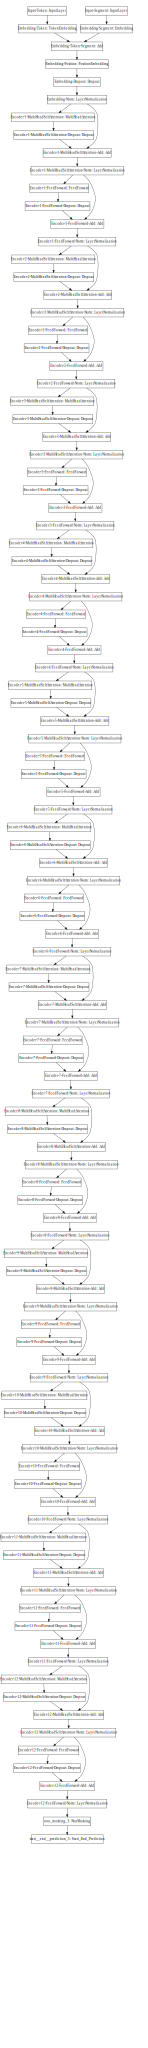

In [123]:
from IPython.display import SVG
from keras.utils import model_to_dot


SVG(model_to_dot(get_bert_finetuning_model(model), dpi=65).create(prog='dot', format='svg'))


훈련을 시작합니다.  
1epoch을 훈련해 보고, 결과를 확인하고 훈련을 다시 시작할 예정입니다.

In [124]:
!nvidia-smi

Sat Feb 29 08:23:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    37W / 250W |   1415MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
sess = K.get_session()
uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
init = tf.variables_initializer([v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables])
sess.run(init)

bert_model = get_bert_finetuning_model(model)
bert_model.summary()
# 훈련 시작
history = bert_model.fit(train_x, train_y, batch_size=12, shuffle=True, verbose=1, epochs=2)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 384)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 384)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 384, 768), ( 23440896    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 384, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

In [0]:
from sklearn.metrics import classification_report
preds = bert_model.predict(train_x)

In [0]:
start_indexes = np.argmax(preds[0], axis=-1)
end_indexes = np.argmax(preds[1], axis=-1)

In [0]:
# start_index의 f1_score 85%
print(classification_report(train_y[0], start_indexes))

# end_index의 f1_score 88%
print(classification_report(train_y[1], end_indexes))

              precision    recall  f1-score   support

           4       1.00      1.00      1.00         1
           6       1.00      0.75      0.86         4
           7       0.67      0.82      0.73        22
           8       0.78      0.83      0.81        65
           9       0.82      0.87      0.84       173
          10       0.85      0.89      0.87       328
          11       0.86      0.86      0.86       464
          12       0.84      0.86      0.85       607
          13       0.85      0.86      0.86       748
          14       0.88      0.87      0.87       849
          15       0.87      0.87      0.87       907
          16       0.89      0.88      0.88       957
          17       0.88      0.89      0.88       963
          18       0.89      0.86      0.87       992
          19       0.86      0.86      0.86      1001
          20       0.87      0.89      0.88       972
          21       0.86      0.87      0.87       988
          22       0.86    

우리가 훈련한 BERT MODEL을 구글 GDrive에 저장합니다.

In [0]:
# 87.7% 79.6%
# 모델 저장하기
path = "gdrive/My Drive/Colab Notebooks/squad"
bert_model.save_weights(path+"/(Uncased)Squad.h5")

In [0]:
# 저장한 bert_model 로드하기
bert_model = get_bert_finetuning_model(model)
path = "gdrive/My Drive/Colab Notebooks/squad"
bert_model.load_weights(path+"/(Uncased)Squad.h5")

우리가 만든 모델이 잘 작동하는지 확인해보도록 하겠습니다.  
모델을 훈련할 때 사용하지 않은 test data로 모델이 잘 작동하는지, 우리가 만든 버트 모델의 성능이 어느정도 되는지 알아보는 시간을 가져보겠습니다.  

SQAUD 데이터 셋에서 test 용도로 쓰이는 dev 파일을 PANDAS DATAFRAME 형식으로 불러오는 함수를 정의합니다.  
train 데이터와 모양이 약간 다르기 때문에, 함수를 새로 정의해야 합니다.

In [0]:
def squad_json_to_dataframe_dev(input_file_path, record_path = ['data','paragraphs','qas','answers'],
                           verbose = 1):
    """
    input_file_path: path to the squad json file.
    record_path: path to deepest level in json file default value is
    ['data','paragraphs','qas','answers']
    verbose: 0 to suppress it default is 1
    """
    if verbose:
        print("Reading the json file")    
    file = json.loads(open(input_file_path).read())
    if verbose:
        print("processing...")
    # parsing different level's in the json file
    js = pd.io.json.json_normalize(file , record_path )
    m = pd.io.json.json_normalize(file, record_path[:-1] )
    r = pd.io.json.json_normalize(file,record_path[:-2])
    
    #combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
    m['context'] = idx
    main = m[['id','question','context','answers']].set_index('id').reset_index()
    main['c_id'] = main['context'].factorize()[0]
    if verbose:
        print("shape of the dataframe is {}".format(main.shape))
        print("Done")
    return main

In [127]:
input_file_path ='dev-v1.1.json'
record_path = ['data','paragraphs','qas','answers']
verbose = 0
dev = squad_json_to_dataframe_dev(input_file_path=input_file_path,record_path=record_path)

Reading the json file
processing...
shape of the dataframe is (10570, 5)
Done


TEST DATA가 잘 불려왔는지 확인해 보겠습니다.

In [128]:
dev

,id,question,context,answers,c_id
0,56be4db0acb8001400a502ec,Which NFL team represented the AFC at Super Bo...,Super Bowl 50 was an American football game to...,"[{'answer_start': 177, 'text': 'Denver Broncos...",0
1,56be4db0acb8001400a502ed,Which NFL team represented the NFC at Super Bo...,Super Bowl 50 was an American football game to...,"[{'answer_start': 249, 'text': 'Carolina Panth...",0
2,56be4db0acb8001400a502ee,Where did Super Bowl 50 take place?,Super Bowl 50 was an American football game to...,"[{'answer_start': 403, 'text': 'Santa Clara, C...",0
3,56be4db0acb8001400a502ef,Which NFL team won Super Bowl 50?,Super Bowl 50 was an American football game to...,"[{'answer_start': 177, 'text': 'Denver Broncos...",0
4,56be4db0acb8001400a502f0,What color was used to emphasize the 50th anni...,Super Bowl 50 was an American football game to...,"[{'answer_start': 488, 'text': 'gold'}, {'answ...",0
...,...,...,...,...,...
10565,5737aafd1c456719005744fb,What is the metric term less used than the New...,"The pound-force has a metric counterpart, less...","[{'answer_start': 82, 'text': 'kilogram-force'...",2066
10566,5737aafd1c456719005744fc,What is the kilogram-force sometimes reffered ...,"The pound-force has a metric counterpart, less...","[{'answer_start': 114, 'text': 'kilopond'}, {'...",2066
10567,5737aafd1c456719005744fd,What is a very seldom used unit of mass in the...,"The pound-force has a metric counterpart, less...","[{'answer_start': 274, 'text': 'slug'}, {'answ...",2066
10568,5737aafd1c456719005744fe,What seldom used term of a unit of force equal...,"The pound-force has a metric counterpart, less...","[{'answer_start': 712, 'text': 'kip'}, {'answe...",2066


train 데이터와 다르게 SQuAD의 dev 데이터의 정답은 1개 이상입니다.  
따라서 여러 정답 중 하나 이상만 버트 모형이 맞춘다면, 정답을 맞춘 것으로 인정하는 것입니다.

In [0]:
# 정답의 개수를 정의하는 칼럼 생성
dev['answer_len'] = dev['answers'].map(lambda x: len(x))

In [130]:
print(dev['answers'][0])
print()
print(dev['answers'][0][0]['text'])

[{'answer_start': 177, 'text': 'Denver Broncos'}, {'answer_start': 177, 'text': 'Denver Broncos'}, {'answer_start': 177, 'text': 'Denver Broncos'}]

Denver Broncos


In [0]:
# 정답들을 다루기 쉽게 리스트로 반환하는 함수 정의
def get_text(text_len, answers):
  # text_len : 질문(question)과 문장(context)에 해당하는 정답의 개수
  # answers : 정답 ex) [{'answer_start': 177, 'text': 'Denver Broncos'}, {'answer_start': 177, 'text': 'Denver Broncos'}, {'answer_start': 177, 'text': 'Denver Broncos'}]
  texts = []
  for i in range(text_len):
    texts.append(answers[i]['text'])
  return texts

In [132]:
# 정답의 개수(3)와 정답들([{'answer_start' : 177, 'text': 'Denver Broncos'}.....])을 인풋으로 받아서
# 정답들을 리스트로 바꿔주는 함수 실행
get_text(3, dev['answers'][0])

['Denver Broncos', 'Denver Broncos', 'Denver Broncos']

In [0]:
# texts 칼럼의 모든 데이터에 대해서 수행
dev['texts'] = dev.apply(lambda x: get_text(x['answer_len'], x['answers']), axis=1)

In [134]:
dev.head(5)

,id,question,context,answers,c_id,answer_len,texts
0,56be4db0acb8001400a502ec,Which NFL team represented the AFC at Super Bo...,Super Bowl 50 was an American football game to...,"[{'answer_start': 177, 'text': 'Denver Broncos...",0,3,"[Denver Broncos, Denver Broncos, Denver Broncos]"
1,56be4db0acb8001400a502ed,Which NFL team represented the NFC at Super Bo...,Super Bowl 50 was an American football game to...,"[{'answer_start': 249, 'text': 'Carolina Panth...",0,3,"[Carolina Panthers, Carolina Panthers, Carolin..."
2,56be4db0acb8001400a502ee,Where did Super Bowl 50 take place?,Super Bowl 50 was an American football game to...,"[{'answer_start': 403, 'text': 'Santa Clara, C...",0,3,"[Santa Clara, California, Levi's Stadium, Levi..."
3,56be4db0acb8001400a502ef,Which NFL team won Super Bowl 50?,Super Bowl 50 was an American football game to...,"[{'answer_start': 177, 'text': 'Denver Broncos...",0,3,"[Denver Broncos, Denver Broncos, Denver Broncos]"
4,56be4db0acb8001400a502f0,What color was used to emphasize the 50th anni...,Super Bowl 50 was an American football game to...,"[{'answer_start': 488, 'text': 'gold'}, {'answ...",0,3,"[gold, gold, gold]"


In [0]:
dev['texts']

0         [Denver Broncos, Denver Broncos, Denver Broncos]
1        [Carolina Panthers, Carolina Panthers, Carolin...
2        [Santa Clara, California, Levi's Stadium, Levi...
3         [Denver Broncos, Denver Broncos, Denver Broncos]
4                                       [gold, gold, gold]
                               ...                        
10565    [kilogram-force, pound-force, kilogram-force (...
10566    [kilopond, kilopond, kilopond, kilopond, kilop...
10567    [slug, metric slug, metric slug, metric slug, ...
10568                            [kip, kip, kip, kip, kip]
10569             [sthène, sthène, sthène, sthène, sthène]
Name: texts, Length: 10570, dtype: object

테스트 데이터에 대해서 결과를 확인합니다.  
훈련에 사용하지 않은 테스트 데이터에 대한 예측을 제법 잘 수행하는 것을 보실 수 있겠습니다.

딥러닝에서 중요한 것 중 하나는 모델의 성능이 얼마나 되는지의 척도입니다.
**F1 Score**와 **Exact Match**를 측정해 보도록 하겠습니다.  
SQuAD에서의 **F1 Score**는 예측 단어들 중에서 얼마나 버트 모형이 예측한 것과 일치하는 지를 나타내는 척도입니다.  
예를 들면, 버트가 정답으로 [new, england, patriots]를 예측하였고, 실제 정답 또한 [new, england, patriots]라면, 예측 단어와 정답 단어가 모두 다 일치하기 때문에 F1 Score는 1.0 입니다.  
만약에, 버트가 정답으로 [england, patriots]만 예측했다면 F1 Score는 세 단어 중 2가지만 예측했기 때문에, 0.66(66%)가 됩니다.  
  
**EM**(Exact Match)은 정답단어들과 예측단어들이 완전히 일치하면 1, 일치하지 않으면 0입니다.  
정답, 예측값 모두 다 [new, england, patriots]가 되어야 합니다.  
  
**F1**과 **EM**을 계산해보도록 하겠습니다.

In [0]:
TEXT_COLUMN = 'texts'

아까 TRAIN 데이터를 버트 인풋으로 변환하기 위한 함수를 살짝 변형하도록 하겠습니다.  
우리가 훈련한 버트 모형을 바탕으로 DEV 데이터를 예측하기 위해서 인풋을 만들어보도록 하겠습니다.  
TRAIN 데이터를 인풋으로 만들기 위한 함수랑 다른 점은, 정답을 출력하지 않는다는 점입니다. 예측만 하면 되니까요.

In [0]:
def convert_data(data_df):
    global tokenizer
    indices, segments, target_start, target_end = [], [], [], []

    for i in tqdm(range(len(data_df))):
        que, _ = tokenizer.encode(data_df[QUESTION_COLUMN][i])
        doc, _ = tokenizer.encode(data_df[DATA_COLUMN][i])
        doc.pop(0)

        que_len = len(que)
        doc_len = len(doc)

        if que_len > 64:
          que = que[:63]
          que.append(102)
        
        if len(que+doc) > SEQ_LEN:
          while len(que+doc) != SEQ_LEN:
            doc.pop(-1)

          doc.pop(-1)
          doc.append(102)

        segment = [0]*len(que) + [1]*len(doc) + [0]*(SEQ_LEN-len(que)-len(doc))
        if len(que + doc) <= SEQ_LEN:
          while len(que+doc) != SEQ_LEN:
            doc.append(0)

        ids = que + doc

        texts = data_df[TEXT_COLUMN][i]
        for text_element in texts:
          text = tokenizer.encode(text_element)[0]

          text_slide_len = len(text[1:-1])
          for j in range(0,(len(doc))):  
              exist_flag = 0
              if text[1:-1] == doc[j:j+text_slide_len]:
                ans_start = j + len(que)
                ans_end = j + text_slide_len - 1 + len(que)
                exist_flag = 1
                break
        
          if exist_flag == 0:
            ans_start = SEQ_LEN
            ans_end = SEQ_LEN

        indices.append(ids)
        segments.append(segment)
        target_start.append(ans_start)
        target_end.append(ans_end)
        
    indices_x = np.array(indices)
    segments = np.array(segments)
    target_start = np.array(target_start)
    target_end = np.array(target_end)

    del_list = np.where(target_start!=SEQ_LEN)[0]
    not_del_list = np.where(target_start==SEQ_LEN)[0]
    indices_x = indices_x[del_list]
    segments = segments[del_list]

    target_start = target_start[del_list]
    target_end = target_end[del_list]
    
    return [indices_x, segments], del_list

def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_df[QUESTION_COLUMN] = data_df[QUESTION_COLUMN].astype(str)
    data_x, data_y, del_list = convert_data(data_df)

    return data_x, data_y, del_list

In [137]:
dev_bert_input = convert_data(dev)

100%|██████████| 10570/10570 [00:24<00:00, 428.98it/s]


In [55]:
dev_bert_input

([array([[  101,  2029,  5088, ...,     0,     0,     0],
         [  101,  2029,  5088, ...,     0,     0,     0],
         [  101,  2073,  2106, ...,     0,     0,     0],
         ...,
         [  101,  2054,  2003, ...,     0,     0,     0],
         [  101,  2054, 15839, ...,     0,     0,     0],
         [  101,  2054,  2003, ...,     0,     0,     0]]),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])],
 array([    0,     1,     2, ..., 10567, 10568, 10569]))

In [0]:
dev_bert_input, del_list = dev_bert_input[0], dev_bert_input[1]
dev = dev.iloc[del_list]
dev = dev.reset_index(drop=True)

In [139]:
dev

,id,question,context,answers,c_id,answer_len,texts
0,56be4db0acb8001400a502ec,Which NFL team represented the AFC at Super Bo...,Super Bowl 50 was an American football game to...,"[{'answer_start': 177, 'text': 'Denver Broncos...",0,3,"[Denver Broncos, Denver Broncos, Denver Broncos]"
1,56be4db0acb8001400a502ed,Which NFL team represented the NFC at Super Bo...,Super Bowl 50 was an American football game to...,"[{'answer_start': 249, 'text': 'Carolina Panth...",0,3,"[Carolina Panthers, Carolina Panthers, Carolin..."
2,56be4db0acb8001400a502ee,Where did Super Bowl 50 take place?,Super Bowl 50 was an American football game to...,"[{'answer_start': 403, 'text': 'Santa Clara, C...",0,3,"[Santa Clara, California, Levi's Stadium, Levi..."
3,56be4db0acb8001400a502ef,Which NFL team won Super Bowl 50?,Super Bowl 50 was an American football game to...,"[{'answer_start': 177, 'text': 'Denver Broncos...",0,3,"[Denver Broncos, Denver Broncos, Denver Broncos]"
4,56be4db0acb8001400a502f0,What color was used to emphasize the 50th anni...,Super Bowl 50 was an American football game to...,"[{'answer_start': 488, 'text': 'gold'}, {'answ...",0,3,"[gold, gold, gold]"
...,...,...,...,...,...,...,...
10523,5737aafd1c456719005744fb,What is the metric term less used than the New...,"The pound-force has a metric counterpart, less...","[{'answer_start': 82, 'text': 'kilogram-force'...",2066,5,"[kilogram-force, pound-force, kilogram-force (..."
10524,5737aafd1c456719005744fc,What is the kilogram-force sometimes reffered ...,"The pound-force has a metric counterpart, less...","[{'answer_start': 114, 'text': 'kilopond'}, {'...",2066,5,"[kilopond, kilopond, kilopond, kilopond, kilop..."
10525,5737aafd1c456719005744fd,What is a very seldom used unit of mass in the...,"The pound-force has a metric counterpart, less...","[{'answer_start': 274, 'text': 'slug'}, {'answ...",2066,5,"[slug, metric slug, metric slug, metric slug, ..."
10526,5737aafd1c456719005744fe,What seldom used term of a unit of force equal...,"The pound-force has a metric counterpart, less...","[{'answer_start': 712, 'text': 'kip'}, {'answe...",2066,5,"[kip, kip, kip, kip, kip]"


In [0]:
# 문장이 토큰화된 것 저장 (1~10527)
indexes = dev_bert_input[0]

In [141]:
indexes

array([[  101,  2029,  5088, ...,     0,     0,     0],
       [  101,  2029,  5088, ...,     0,     0,     0],
       [  101,  2073,  2106, ...,     0,     0,     0],
       ...,
       [  101,  2054,  2003, ...,     0,     0,     0],
       [  101,  2054, 15839, ...,     0,     0,     0],
       [  101,  2054,  2003, ...,     0,     0,     0]])

In [0]:
# 버트 예측(384차원)
bert_predictions = bert_model.predict(dev_bert_input)

In [143]:
bert_predictions

[array([[4.5046983e-07, 8.2021506e-07, 4.2243002e-07, ..., 3.9619800e-07,
         3.9627736e-07, 3.9691542e-07],
        [3.5265381e-07, 6.3832340e-07, 3.5860825e-07, ..., 3.1206858e-07,
         3.1224306e-07, 3.1323265e-07],
        [1.8186619e-06, 4.2199181e-06, 6.4185650e-07, ..., 4.0183440e-07,
         4.0148277e-07, 4.0014453e-07],
        ...,
        [8.4676009e-07, 1.5694970e-06, 2.4437864e-07, ..., 2.3756277e-07,
         2.3934587e-07, 2.3976554e-07],
        [7.9948750e-06, 9.1278685e-07, 1.1206664e-06, ..., 4.5795409e-07,
         4.6148909e-07, 4.5440413e-07],
        [1.7398277e-06, 1.0472634e-06, 1.9529806e-07, ..., 1.8871295e-07,
         1.8935978e-07, 1.8979549e-07]], dtype=float32),
 array([[1.9190898e-06, 1.3929861e-06, 7.9231029e-07, ..., 7.6027987e-07,
         7.5993921e-07, 7.6107352e-07],
        [7.7802014e-07, 5.3432677e-07, 2.9617212e-07, ..., 2.8263986e-07,
         2.8237960e-07, 2.8302773e-07],
        [7.0246110e-06, 3.0644499e-06, 7.7331504e-07, ...,

In [0]:
# 예측값 중 가장 큰 값을 가진 부분 추출(가장 큰 확률이 위치해있는 곳)
start_indexes = np.argmax(bert_predictions[0], axis=-1)
end_indexes = np.argmax(bert_predictions[1], axis=-1)

In [0]:
# 정답 중 의미없는 부분 삭제
# 첫 번째 토큰에 해당하는 start_indexes가 마지막 토큰에 해당하는 end_indexes보다 작다면
# 말이 안 되므로, 이러한 경우를 제거
not_del_list = np.where(start_indexes <= end_indexes)[0]

In [146]:
not_del_list.shape

(10283,)

In [0]:
start_indexes = start_indexes[not_del_list]
end_indexes = end_indexes[not_del_list]
indexes = indexes[not_del_list]

In [148]:
start_indexes[0:100]

array([ 46,  57,  78,  43, 118,  16,  72,  42,  16,  22,  73,  41,  80,
        91, 156,  35,  83,  91,  80,  58,  77,  31,  42,  53,  41,  35,
        42,  77,  11,  44,  27, 133,  66,  40,  87,  44,  43,  83, 127,
        26,  28,  33,  87, 127,  95,  25,  43, 132,  42,  29,  44,  46,
        24,  44,  65,  58,  81,  14,  59,  72,  25,  36,  57,  43,  77,
        64,  60,  75,  84,  59,  70,  40,  41,  49,  61,  56,  38,  47,
        61,  74,  16,  34,  55,  65,  76,  15,  31,  62,  62,  12,  36,
        67,  97,   9,  31,  56,  66,  10,  55,  62])

In [149]:
end_indexes[0:100]

array([ 47,  58,  81,  44, 118,  34,  75,  43,  34,  24,  76,  42,  83,
        92, 158,  35,  83,  92,  83,  60,  80,  74,  43,  54,  42,  35,
        43,  80,  13,  45,  28, 133,  66,  41,  89,  45,  44,  85, 127,
        27,  30,  34,  90, 127,  97,  26,  44, 132,  43,  30,  45,  47,
        25,  45,  65,  59,  81,  14,  60,  72,  25,  36,  58,  43,  77,
        65,  60,  75,  84,  60,  70,  40,  47,  50,  62,  56,  39,  47,
        62,  74,  16,  36,  56,  68,  80,  15,  33,  65,  65,  12,  38,
        70,  97,   9,  33,  57,  69,  10,  56,  65])

In [0]:
# dev 데이터셋 재조정
dev = dev.iloc[not_del_list].reset_index(drop=True)

In [151]:
dev

,id,question,context,answers,c_id,answer_len,texts
0,56be4db0acb8001400a502ec,Which NFL team represented the AFC at Super Bo...,Super Bowl 50 was an American football game to...,"[{'answer_start': 177, 'text': 'Denver Broncos...",0,3,"[Denver Broncos, Denver Broncos, Denver Broncos]"
1,56be4db0acb8001400a502ed,Which NFL team represented the NFC at Super Bo...,Super Bowl 50 was an American football game to...,"[{'answer_start': 249, 'text': 'Carolina Panth...",0,3,"[Carolina Panthers, Carolina Panthers, Carolin..."
2,56be4db0acb8001400a502ee,Where did Super Bowl 50 take place?,Super Bowl 50 was an American football game to...,"[{'answer_start': 403, 'text': 'Santa Clara, C...",0,3,"[Santa Clara, California, Levi's Stadium, Levi..."
3,56be4db0acb8001400a502ef,Which NFL team won Super Bowl 50?,Super Bowl 50 was an American football game to...,"[{'answer_start': 177, 'text': 'Denver Broncos...",0,3,"[Denver Broncos, Denver Broncos, Denver Broncos]"
4,56be4db0acb8001400a502f0,What color was used to emphasize the 50th anni...,Super Bowl 50 was an American football game to...,"[{'answer_start': 488, 'text': 'gold'}, {'answ...",0,3,"[gold, gold, gold]"
...,...,...,...,...,...,...,...
10278,5737aafd1c456719005744fb,What is the metric term less used than the New...,"The pound-force has a metric counterpart, less...","[{'answer_start': 82, 'text': 'kilogram-force'...",2066,5,"[kilogram-force, pound-force, kilogram-force (..."
10279,5737aafd1c456719005744fc,What is the kilogram-force sometimes reffered ...,"The pound-force has a metric counterpart, less...","[{'answer_start': 114, 'text': 'kilopond'}, {'...",2066,5,"[kilopond, kilopond, kilopond, kilopond, kilop..."
10280,5737aafd1c456719005744fd,What is a very seldom used unit of mass in the...,"The pound-force has a metric counterpart, less...","[{'answer_start': 274, 'text': 'slug'}, {'answ...",2066,5,"[slug, metric slug, metric slug, metric slug, ..."
10281,5737aafd1c456719005744fe,What seldom used term of a unit of force equal...,"The pound-force has a metric counterpart, less...","[{'answer_start': 712, 'text': 'kip'}, {'answe...",2066,5,"[kip, kip, kip, kip, kip]"


In [0]:
# length : dev 데이터의 길이
length = len(dev)

In [0]:
sentences = []

untokenized = []

for j in range(len(start_indexes)):
  sentence = []
  for i in range(start_indexes[j], end_indexes[j]+1):
    token_based_word = reverse_token_dict[indexes[j][i]]
    sentence.append(token_based_word)
    # 문장이 토큰화된 단어 하나 하나를 sentence에 저장
  
  sentence_string = ""
  
  for w in sentence:
    
    if w.startswith("##"):
      w = w.replace("##", "")
      # 만약 sentence 안의 토큰이 ##으로 시작한다면, ##을 제거
    else:
      w = " " + w
      # 토큰이 ##으로 시작하지 않는다면 글자의 첫 시작이므로, 띄어쓰기 추가
    sentence_string += w
      # 리스트로 되어 있는 토큰들을 하나로 합쳐줌
  if sentence_string.startswith(" "):
    sentence_string = "" + sentence_string[1:]
    # sentence_string이 " "로 시작하는 경우에는 띄어쓰기를 삭제
  untokenized.append(sentence_string)
  # 리스트로 되어있는 토큰들을 하나로 합쳐준 것, 이것을 untokenized에 저장
  sentences.append(sentence)

In [154]:
print(sentences[:30])
print(untokenized[:30])

[['denver', 'broncos'], ['carolina', 'panthers'], ['levi', "'", 's', 'stadium'], ['denver', 'broncos'], ['gold'], ['american', 'football', 'game', 'to', 'determine', 'the', 'champion', 'of', 'the', 'national', 'football', 'league', '(', 'nfl', ')', 'for', 'the', '2015', 'season'], ['february', '7', ',', '2016'], ['denver', 'broncos'], ['american', 'football', 'game', 'to', 'determine', 'the', 'champion', 'of', 'the', 'national', 'football', 'league', '(', 'nfl', ')', 'for', 'the', '2015', 'season'], ['national', 'football', 'league'], ['february', '7', ',', '2016'], ['denver', 'broncos'], ['levi', "'", 's', 'stadium'], ['santa', 'clara'], ['super', 'bowl', 'l'], ['2015'], ['2016'], ['santa', 'clara'], ['levi', "'", 's', 'stadium'], ['24', '–', '10'], ['february', '7', ',', '2016'], ['2015', 'season', '.', 'the', 'american', 'football', 'conference', '(', 'afc', ')', 'champion', 'denver', 'broncos', 'defeated', 'the', 'national', 'football', 'conference', '(', 'nfc', ')', 'champion', 'c

In [0]:
dev_answers = []
for i in range(length):
  dev_answer = []
  texts_dict = dev['answers'][i]
  
  for j in range(len(texts_dict)):
    dev_answer.append(texts_dict[j]['text'])
    # 정답 하나 하나를 리스트로 저장
  dev_answers.append(dev_answer)

In [156]:
dev_answers[0:10]

[['Denver Broncos', 'Denver Broncos', 'Denver Broncos'],
 ['Carolina Panthers', 'Carolina Panthers', 'Carolina Panthers'],
 ['Santa Clara, California',
  "Levi's Stadium",
  "Levi's Stadium in the San Francisco Bay Area at Santa Clara, California."],
 ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'],
 ['gold', 'gold', 'gold'],
 ['"golden anniversary"', 'gold-themed', '"golden anniversary'],
 ['February 7, 2016', 'February 7', 'February 7, 2016'],
 ['American Football Conference',
  'American Football Conference',
  'American Football Conference'],
 ['"golden anniversary"', 'gold-themed', 'gold'],
 ['American Football Conference',
  'American Football Conference',
  'American Football Conference']]

In [0]:
dev_tokens = []
for i in dev_answers:
  dev_tokened = []
  for j in i:
    temp_token = tokenizer.tokenize(j)
    # 정답을 토큰화
    temp_token.pop(0)
    # [CLS] 제거
    temp_token.pop(-1)
    # [SEP] 제거
    dev_tokened.append(temp_token)
  dev_tokens.append(dev_tokened)

In [158]:
print(dev_tokens[:5])

[[['denver', 'broncos'], ['denver', 'broncos'], ['denver', 'broncos']], [['carolina', 'panthers'], ['carolina', 'panthers'], ['carolina', 'panthers']], [['santa', 'clara', ',', 'california'], ['levi', "'", 's', 'stadium'], ['levi', "'", 's', 'stadium', 'in', 'the', 'san', 'francisco', 'bay', 'area', 'at', 'santa', 'clara', ',', 'california', '.']], [['denver', 'broncos'], ['denver', 'broncos'], ['denver', 'broncos']], [['gold'], ['gold'], ['gold']]]


In [0]:
# 토큰화된 정답을 문장으로 변환시켜주고 합쳐줌
dev_answer_lists = []
for dev_answers in dev_tokens:
  dev_answer_list = []
  for dev_answer in dev_answers:
    dev_answer_string = " ".join(dev_answer)
    dev_answer_list.append(dev_answer_string)
  dev_answer_lists.append(dev_answer_list)

In [160]:
print(dev_answer_lists[:5])

[['denver broncos', 'denver broncos', 'denver broncos'], ['carolina panthers', 'carolina panthers', 'carolina panthers'], ['santa clara , california', "levi ' s stadium", "levi ' s stadium in the san francisco bay area at santa clara , california ."], ['denver broncos', 'denver broncos', 'denver broncos'], ['gold', 'gold', 'gold']]


In [0]:
# untokenizing
dev_strings_end = []
for dev_strings in dev_answer_lists:
  dev_strings_processed = []
  for dev_string in dev_strings:
    dev_string = dev_string.replace(" ##", "")
    dev_strings_processed.append(dev_string)
  dev_strings_end.append(dev_strings_processed)

In [0]:
dev_answers = dev_strings_end 

In [163]:
print(dev_answers[:5])

[['denver broncos', 'denver broncos', 'denver broncos'], ['carolina panthers', 'carolina panthers', 'carolina panthers'], ['santa clara , california', "levi ' s stadium", "levi ' s stadium in the san francisco bay area at santa clara , california ."], ['denver broncos', 'denver broncos', 'denver broncos'], ['gold', 'gold', 'gold']]


F1 SCORE와 EXACT MATCH를 계산하는 함수 정의  
출처 : https://github.com/allenai/bi-att-flow/blob/master/squad/evaluate-v1.1.py

In [0]:
from collections import Counter
import string

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def f1_score(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def exact_match_score(prediction, ground_truth):
    return (normalize_answer(prediction) == normalize_answer(ground_truth))

def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
    scores_for_ground_truths = []
    for ground_truth in ground_truths:
        score = metric_fn(prediction, ground_truth)
        scores_for_ground_truths.append(score)
    return max(scores_for_ground_truths)

In [165]:
f1_sum = 0

for i in range(len(untokenized)):
  f1 = metric_max_over_ground_truths(f1_score, untokenized[i], dev_answers[i])
  f1_sum += f1
print("f1 score : ", f1_sum / length)

f1 score :  0.8743697019675727


In [166]:
EM_sum = 0

for i in range(len(untokenized)):
  
  EM = metric_max_over_ground_truths(exact_match_score, untokenized[i], dev_answers[i])
  EM_sum += EM
print("EM Score : ", EM_sum / length)

EM Score :  0.7902363123602062


In [0]:
def convert_data(data_df):
    global tokenizer
    indices, segments = [], []

  
    que, _ = tokenizer.encode(data_df[QUESTION_COLUMN])
    doc, _ = tokenizer.encode(data_df[DATA_COLUMN])
    doc.pop(0)

    que_len = len(que)
    doc_len = len(doc)

    if que_len > 64:
      que = que[:63]
      que.append(102)
        
    if len(que+doc) > SEQ_LEN:
      while len(que+doc) != SEQ_LEN:
        doc.pop(-1)

      doc.pop(-1)
      doc.append(102)

    segment = [0]*len(que) + [1]*len(doc) + [0]*(SEQ_LEN-len(que)-len(doc))
    if len(que + doc) <= SEQ_LEN:
      while len(que+doc) != SEQ_LEN:
        doc.append(0)

    ids = que + doc


    indices.append(ids)
    segments.append(segment)
    indices = np.array(indices)
    segments = np.array(segments)
    return [indices, segments]

In [0]:
def predict_letter(df):
  
  test_input = convert_data(df)
  test_start, test_end = bert_model.predict(test_input)
  
  indexes = test_input[0].tolist()[0]
  start = np.argmax(test_start, axis=1).item()
  end = np.argmax(test_end, axis=1).item()
  start_tok = indexes[start]
  end_tok = indexes[end]

  print("Question : ", df['question'])
  print("-"*50)
  print("Context : ", end = " ")
  
  def split_text(text, n):
    for line in text.splitlines():
        while len(line) > n:
           x, line = line[:n], line[n:]
           yield x
        yield line
  
  for line in split_text(df['context'], 150):
    print(line)

  print("-"*50)
  print("ANSWER : ", end = " ")
  print("\n")
  sentences = []
  
  for i in range(start, end+1):
    token_based_word = reverse_token_dict[indexes[i]]
    sentences.append(token_based_word)
    print(token_based_word, end= " ")
  
  print("\n")
  print("Untokenized Answer : ", end = "")
  for w in sentences:
    if w.startswith("##"):
      w = w.replace("##", "")
    else:
      w = " " + w
    
    print(w, end="")
  print("")

임의의 Question과 Context를 받아서, 정답을 맞춰보는 것을 실험해보도록 하겠습니다.  


In [87]:
import random
for i in random.sample(range(300),300):
  answers = dev['answers'][i]
  predict_letter(dev.iloc[i])
  print("")
  print("real answer : ", answers)
  print("")

Question :  How many fumbles did Von Miller force?
--------------------------------------------------
Context :  The Broncos took an early lead in Super Bowl 50 and never trailed. Newton was limited by Denver's defense, which sacked him seven times and forced him
 into three turnovers, including a fumble which they recovered for a touchdown. Denver linebacker Von Miller was named Super Bowl MVP, recording five 
solo tackles, 2½ sacks, and two forced fumbles.
--------------------------------------------------
ANSWER :  

two 

Untokenized Answer :  two

real answer :  [{'answer_start': 328, 'text': 'two'}, {'answer_start': 328, 'text': 'two'}, {'answer_start': 328, 'text': 'two'}]

Question :  How many fumbles did Von Miller force in Super Bowl 50?
--------------------------------------------------
Context :  The Broncos took an early lead in Super Bowl 50 and never trailed. Newton was limited by Denver's defense, which sacked him seven times and forced him
 into three turnovers, includ